# Spam Collection using Naive Bayes
### we wil use SMSSpamCollection dataset for classification

## Importing Required Libraries 

In [1]:
import pandas as pd
from collections import Counter
import math
import matplotlib.pyplot as plt
import csv

## Loading DataSet 
### Separating the spam and ham messages in lists

In [2]:
messages = pd.read_csv('training.csv', sep='\t', quoting=csv.QUOTE_NONE, names=["label", "message"])
messages = messages.dropna() # drop empty row
spam = []
ham = []
for index, row in messages.iterrows():
    if row.label == 'spam':
        spam.append(row.message)
    if row.label == 'ham':
        ham.append(row.message)
len(messages)


5537

## Preprocessing

In [3]:
def cleanText(string):
    string = string.lower()
    string = string.replace(". ", " ")
    string = string.replace(": ", " ")
    string = string.replace("?"," ")
    string = string.replace("!"," ")
    string = string.replace(";", " ")
    string = string.replace(",", " ")
    return string

## Cleaning Data

In [4]:
ham = [cleanText(i) for i in ham]
spam = [cleanText(i) for i in spam]

## Counting the frquencies of token by spliting the massage with spaces for ham

In [5]:
wordCntForHam = Counter()
for row in ham:
    for word in row.split(' '):
        wordCntForHam[word] += 1
wordCntForHam

Counter({'i': 2192,
         'see': 137,
         'the': 1118,
         'letter': 3,
         'b': 53,
         'on': 384,
         'my': 741,
         'car': 36,
         'anything': 68,
         'lor..': 38,
         'u': 954,
         'decide...': 1,
         'hello': 38,
         '': 5013,
         "how's": 29,
         'you': 1798,
         'and': 844,
         'how': 254,
         'did': 114,
         'saturday': 7,
         'go': 241,
         'was': 220,
         'just': 288,
         'texting': 5,
         'to': 1552,
         'if': 349,
         "you'd": 8,
         'decided': 16,
         'do': 372,
         'tomo': 18,
         'not': 402,
         'that': 468,
         "i'm": 367,
         'trying': 28,
         'invite': 3,
         'myself': 9,
         'or': 227,
         'pls': 100,
         'ahead': 6,
         'with': 266,
         'watts': 1,
         'wanted': 26,
         'be': 326,
         'sure': 69,
         'have': 436,
         'a': 1053,
         'great': 9

## Counting the frquencies of token by spliting the massage with spaces for spam

In [6]:
wordCntForSpam = Counter()
for row in spam:
    for word in row.split(' '):
        wordCntForSpam[word] += 1
wordCntForSpam

Counter({'07732584351': 1,
         '-': 54,
         'rodger': 1,
         'burns': 1,
         'msg': 25,
         '=': 5,
         'we': 48,
         'tried': 17,
         'to': 672,
         'call': 342,
         'you': 281,
         're': 9,
         'your': 259,
         'reply': 102,
         'our': 84,
         'sms': 24,
         'for': 199,
         'a': 375,
         'free': 210,
         'nokia': 65,
         'mobile': 120,
         '+': 18,
         'camcorder': 15,
         'please': 51,
         'now': 197,
         '08000930705': 14,
         'delivery': 21,
         'tomorrow': 9,
         'ac': 4,
         'sptv': 2,
         'the': 198,
         'new': 69,
         'jersey': 1,
         'devils': 1,
         'and': 120,
         'detroit': 1,
         'red': 1,
         'wings': 1,
         'play': 18,
         'ice': 1,
         'hockey': 1,
         'correct': 4,
         'or': 185,
         'incorrect': 1,
         '': 1089,
         'end': 13,
         'congrats'

## Delete any token that are less than 3 characters in length and apply laplace smoothing 

In [7]:
hamClean = wordCntForHam.copy()
spamClean = wordCntForSpam.copy()

for i in wordCntForHam:
    if len(i) <= 2:
        del hamClean[i]
        
for i in wordCntForSpam:
    if len(i) <= 2:
        del spamClean[i]

for i in hamClean:
    hamClean[i] = wordCntForHam[i] + 1
    
for i in spamClean:
    spamClean[i] = wordCntForSpam[i] + 1

##  Find the Probabilities of the words given that they are an ham message or spam message

In [8]:
probHam = {}
probSpam = {}

for i in hamClean:
    probHam[i] = math.log(float(hamClean[i])/sum(hamClean.values()))

for i in spamClean:
    probSpam[i] = math.log(float(spamClean[i])/sum(spamClean.values()))

## Load test dataset

In [16]:
testMessages = pd.read_csv('test.csv', sep='\t', quoting=csv.QUOTE_NONE, names=["label", "message"], encoding = 'unicode_escape')
testMessages = testMessages.dropna()
testMessages
testMessages['message'] = [cleanText(i) for i in testMessages['message']]
testMessages['message']

0     go until jurong point  crazy. available only i...
1                          ok lar.. joking wif u oni...
2     free entry in 2 a wkly comp to win fa cup fina...
3      u dun say so early hor.. u c already then say...
4     nah i don't think he goes to usf  he lives aro...
5     freemsg hey there darling it's been 3 week's n...
6     even my brother is not like to speak with me t...
7     as per your request 'melle melle (oru minnamin...
8     winner   as a valued network customer you have...
9     had your mobile 11 months or more  u r entitle...
10    i'm gonna be home soon and i don't want to tal...
11    six chances to win cash  from 100 to 20 000 po...
12    urgent  you have won a 1 week free membership ...
13    i've been searching for the right words to tha...
14                  i have a date on sunday with will  
15    xxxmobilemovieclub to use your credit  click t...
16                           oh k...i'm watching here:)
17    eh u remember how 2 spell his name.. yes i

## Thats a process to find the message is ham or spam using probabilities of token that we calculate above 
### In this process: splitting the row by spaces and look up the word probablity of being an ham or spam message

In [17]:
results = []

for index, row in testMessages.iterrows():
    hamSum = 0
    spamSum = 0
    for word in row.message.split(' '):
        if len(word) <= 2:
            hamSum += 0
            spamSum += 0
        else:
            if word in probHam:
                hamSum += probHam[word]
            else:
                hamSum += math.log(float(1)/sum(hamClean.values()))
                
            if word in probSpam:
                spamSum += probSpam[word]
            else:
                spamSum += math.log(float(1)/sum(spamClean.values()))
    if hamSum > spamSum:
        results.append('ham')
    else:
        results.append('spam')

## results

In [18]:
testMessages['prediction'] = results
testMessages

,label,message,prediction
0,ham,go until jurong point crazy. available only i...,ham
1,ham,ok lar.. joking wif u oni...,ham
2,spam,free entry in 2 a wkly comp to win fa cup fina...,spam
3,ham,u dun say so early hor.. u c already then say...,ham
4,ham,nah i don't think he goes to usf he lives aro...,ham
5,spam,freemsg hey there darling it's been 3 week's n...,spam
6,ham,even my brother is not like to speak with me t...,ham
7,ham,as per your request 'melle melle (oru minnamin...,spam
8,spam,winner as a valued network customer you have...,spam
9,spam,had your mobile 11 months or more u r entitle...,spam


## import classification_report, accuracy_score, confusion_matrix

In [19]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import sklearn

### Accuracy score and confusion matrix

In [20]:
print('accuracy', accuracy_score(testMessages['label'], testMessages['prediction']))
print('confusion matrix\n', confusion_matrix(testMessages['label'], testMessages['prediction']))
print('(row=expected, col=predicted)')

accuracy 0.9459459459459459
confusion matrix
 [[26  2]
 [ 0  9]]
(row=expected, col=predicted)


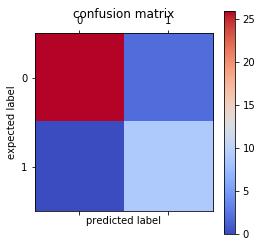

In [21]:
plt.matshow(confusion_matrix(testMessages['label'], testMessages['prediction']), cmap=plt.cm.coolwarm, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

## Classification report including f1_score, precision and recall

In [22]:
print(classification_report(testMessages['label'], testMessages['prediction']))

              precision    recall  f1-score   support

         ham       1.00      0.93      0.96        28
        spam       0.82      1.00      0.90         9

   micro avg       0.95      0.95      0.95        37
   macro avg       0.91      0.96      0.93        37
weighted avg       0.96      0.95      0.95        37



# Thankyou!